In [3]:
# since you first have to create a virtual environment it get created with no jupyter notebooks preinstalled, so:
# pip install --user ipykernel - this install the jupyter kernel 
# python -m ipykernel install --user --name=myenv - this creates the environment as kernel
#I think there is no need to do have a virtual environment heret since it's just a notebook with analysis, 

In [ ]:
# Run these pip install commands from the command line if Jupyter Notebook is not yet installed.
# Otherwise, see Google Collab link above for an in-notebook example
pip install duckdb

# Install Jupyter Notebook (Note: you can also install JupyterLab: pip install jupyterlab) 
pip install notebook

# Install supporting libraries
pip install jupysql
pip install duckdb-engine
pip install pandas       # conda install pandas (in case pip fails)
pip install matplotlib

In [2]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

There's a new jupysql version available (0.6.6), you're running 0.6.2. To upgrade: pip install jupysql --upgrade


In [3]:
#Importing all the required packages
from chessdotcom import client, get_player_game_archives
from datetime import datetime
import pprint
import requests
import pandas as pd
import duckdb 

In [4]:
username = 'chiopra'

printer = pprint.PrettyPrinter()

def print_stats(username):
    data = client.get_player_stats(username, tts=0)
    printer.pprint(data.json)

print_stats(username)

{'stats': {'chess_blitz': {'best': {'date': 1437375600,
                                    'game': 'https://www.chess.com/game/live/64361468515',
                                    'rating': 1200},
                           'last': {'date': 1678741839,
                                    'rating': 867,
                                    'rd': 46},
                           'record': {'draw': 32, 'loss': 535, 'win': 560}},
           'chess_bullet': {'last': {'date': 1669305049,
                                     'rating': 871,
                                     'rd': 202},
                            'record': {'draw': 0, 'loss': 3, 'win': 0}},
           'chess_rapid': {'best': {'date': 1677763272,
                                    'game': 'https://www.chess.com/game/live/71582671427',
                                    'rating': 1306},
                           'last': {'date': 1677844996,
                                    'rating': 1294,
                              

### A/B Test: Playing more than 4 games per day leads to better results

In [5]:
dates = []
results = []

def appending_results(values):
    if values['result'] == 'win':
        results.append('win')
    elif values['result'] == 'draw':
        results.append('draw')
    else:
        results.append('loss')
    return results

def get_games(username):
    data = get_player_game_archives(username)
    print(data)
    for key,value in data.json.items():
        for url in value:
            games = requests.get(url).json()
            for game in games['games']:
                for k, v in game.items():
                    if k == 'end_time':
                        date = datetime.utcfromtimestamp(v).strftime('%Y-%m-%d')
                        dates.append(date)
                    if k == 'white' and v['username'] == 'chiopra':
                        results = appending_results(v)
                    elif k == 'black' and v['username'] == 'chiopra':
                        results = appending_results(v)
    return dates, results

dates, results = get_games(username)


#                 if game['time_class'] == 'rapid':
#                     for k, v in game.items():
#                         print(k)
                #for tomorrow just the date and the result, loss or win to df and then do aggregate function to get wins/losses per day
#                 print(type(game))
#                 df = pd.DataFrame.from_dict(game, orient = 'columns')
#                 print(df)
#                 print
#                 print(df.columns)
#                 string = df['pgn'].to_string(index=False)
#                 print(string)
#                 for i in string.split('"'):
#                     print(i)
#                 break;
#             break;
              
    # for i in data['Archives']:
    #     print(i)
    # printer.pprint(data.json)

# get_games(username)

# print(requests.get('https://www.chess.com/game/live/1221711014').content())

ChessDotComResponse(archives=['https://api.chess.com/pub/player/chiopra/games/2015/07', 'https://api.chess.com/pub/player/chiopra/games/2020/07', 'https://api.chess.com/pub/player/chiopra/games/2020/12', 'https://api.chess.com/pub/player/chiopra/games/2021/03', 'https://api.chess.com/pub/player/chiopra/games/2021/06', 'https://api.chess.com/pub/player/chiopra/games/2021/07', 'https://api.chess.com/pub/player/chiopra/games/2021/08', 'https://api.chess.com/pub/player/chiopra/games/2021/09', 'https://api.chess.com/pub/player/chiopra/games/2021/10', 'https://api.chess.com/pub/player/chiopra/games/2021/11', 'https://api.chess.com/pub/player/chiopra/games/2021/12', 'https://api.chess.com/pub/player/chiopra/games/2022/01', 'https://api.chess.com/pub/player/chiopra/games/2022/02', 'https://api.chess.com/pub/player/chiopra/games/2022/03', 'https://api.chess.com/pub/player/chiopra/games/2022/04', 'https://api.chess.com/pub/player/chiopra/games/2022/09', 'https://api.chess.com/pub/player/chiopra/

In [6]:
import numpy as np

df = pd.DataFrame({'dates': dates,
                   'results': results})

In [7]:
#without \ you could not have separate rows for sql script
%sql df_agg << WITH fully AS \
(SELECT *,cast(count(dates) as float) as count \
FROM df GROUP BY dates, results), \
sub as \
(SELECT dates, cast(count(dates) as float) as games \
FROM df GROUP BY dates) \
select f.*, s.games, (f.count/s.games)*100 as percentage from fully f \
left join sub s on s.dates = f.dates \
where f.results = 'win' and games > 1 and games < 18



In [8]:
df_agg.head()
# print(df_agg['games'].sum())

,dates,results,count,games,percentage
0,2020-07-13,win,5.0,11.0,45.454548
1,2020-07-15,win,2.0,7.0,28.571430
2,2020-12-01,win,1.0,3.0,33.333336
3,2020-12-03,win,3.0,5.0,60.000004
4,2020-12-04,win,2.0,2.0,100.000000


In [9]:
%sql df_average << select games, avg(percentage) \
from df_agg \
group by games

In [10]:
%sql df_count << select games, count(games) \
from df_agg \
group by games

In [11]:
%sql df_overall_avg << select sum(count)/sum(games)*100 as overall \
from df_agg 


In [12]:
df_overall_avg.head()

,overall
0,53.180915


In [13]:
df_average.head()

,games,avg(percentage)
0,11.0,51.515153
1,7.0,53.571431
2,3.0,43.333337
3,5.0,46.666668
4,2.0,68.750000


<BarContainer object of 15 artists>

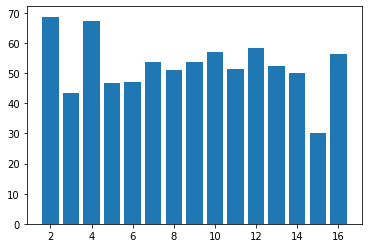

In [14]:
import matplotlib.pyplot as plt

plt.bar(df_average['games'], df_average['avg(percentage)'])

<BarContainer object of 15 artists>

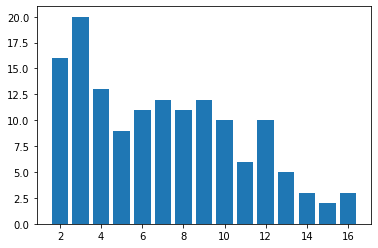

In [15]:
import matplotlib.pyplot as plt

plt.bar(df_count['games'], df_count['count(games)'])

### Performance questions:
 #### - does performance change with games per day ?
 #### - is performance impacted by the puzzles done in a day ?
 #### - does consistency have impact on performance ?
 #### - 

In [16]:
#I am moving on from puzzles data as there is no api endpoint or even website for that, so for now I will try to answer other performance questions

In [20]:
%sql df_dates << select cast(dates as date) as dates, cast(lag(dates) over(order by dates) as date) as previous_date, \
from df group by dates


# select dates, datediff('day', lag(dates, -1), dates), row_number() over() \
# from df \
# group by dates


In [26]:
%sql df_last_game << select dates, previous_date, \
date_diff('day', previous_date, dates) as days_since_last_game\
,case when days_since_last_game <> 1 then 0 else 1 end as streak_day, \
case when streak_day = 0 then 0 else
streak + lag(streak_day) OVER () as streak \
from df_dates \
where previous_date is not null and dates is not null 

(duckdb.BinderException) Binder Error: Column "streak" referenced that exists in the SELECT clause - but this column cannot be referenced before it is defined
[SQL: select dates, previous_date, date_diff('day', previous_date, dates) as days_since_last_game ,case when days_since_last_game <> 1 then 0 else 1 end as streak_day, streak + lag(streak_day) OVER () as streak from df_dates where previous_date is not null and dates is not null]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [25]:
df_last_game.head()

,dates,previous_date,days_since_last_game,streak_day,streak
0,2020-07-12,2015-07-20,1819,0,NaN
1,2020-07-13,2020-07-12,1,1,1.0
2,2020-07-14,2020-07-13,1,1,2.0
3,2020-07-15,2020-07-14,1,1,2.0
4,2020-07-21,2020-07-15,6,0,1.0


In [ ]:
import matplotlib.pyplot as plt

plt.bar(df_last_game['games'], df_count['count(games)'])

In [15]:
%sql select current_date
# SELECT COUNT(*) AS streak \
# FROM ( \
#   SELECT DATE(dates) as dates \
#   FROM df \
#   ORDER BY dates DESC \
# ) AS t1 \
# WHERE dates >= DATE('now', '-n days') AND \
#   dates <= DATE('now') AND \
#   NOT EXISTS ( \
#     SELECT * \
#     FROM ( \
#       SELECT DATE(dates) as dates \
#       FROM df  \
#       ORDER BY dates DESC \
#       LIMIT 1 OFFSET n \
#     ) AS t2 \
#     WHERE t1.dates <= t2.dates \
#   )

,current_date()
0,2023-03-17


In [27]:
#without \ you could not have separate rows for sql script
%sql df_wins << WITH fully AS \
(SELECT *,cast(count(dates) as float) as count \
FROM df GROUP BY dates, results), \
sub as \
(SELECT dates, cast(count(dates) as float) as games \
FROM df GROUP BY dates) \
select f.*, s.games, (f.count/s.games)*100 as percentage, \
DATEADD(DAY, -ROW_NUMBER() OVER(order by dates), dates)\
left join sub s on s.dates = f.dates \
where f.results = 'win' \
order by f.dates asc;

UsageError: unrecognized arguments: -ROW_NUMBER() OVER(order by dates), dates) left join sub s on s.dates = f.dates where f.results = 'win' order by f.dates asc;


In [ ]:
#no dateadd function, I guess it only exists in sql server

In [20]:
print(df_wins['dates'])

0      2020-07-13
1      2020-07-14
2      2020-07-15
3      2020-07-21
4      2020-12-01
          ...    
179    2023-02-28
180    2023-03-01
181    2023-03-02
182    2023-03-03
183    2023-03-09
Name: dates, Length: 184, dtype: object
